# **PROBLEMA DE NEGOCIO**


---




### Una tienda online de moda, con presencia en todo Brasil, necesita impulsar su rendimiento utilizando sus datos de manera estratégica. Como científico de datos, has sido convocado para analizar estos datos y ofrecer insights que guíen sus decisiones y respondan a las siguientes preguntas clave:

### **Preguntas**

1. ¿Cual es el Top 5 productos más vendidos históricamente?

2. ¿Cual es la evolución histórica de las ingresos netos?

3. ¿Cuáles son los ingresos netos por vendedor por año?

4. ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?

# **1. Configuración del Ambiente**


---




In [1]:
# !pip install geobr
import geobr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import FancyBboxPatch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
from sqlalchemy import create_engine, MetaData, Table, Column, Integer, String, Float, Date, ForeignKey, text
from sqlalchemy.orm import sessionmaker
import mplcyberpunk
import squarify
from ipysankeywidget import SankeyWidget
from ipywidgets import Layout

plt.style.use("cyberpunk")

# **2. Creacion de Consultas SQL**


---


In [2]:
# Crearemos una base de datos sql con sqlalchemy
def crear_conexion():
  # Crear conexión a la base de datos
  engine = create_engine('sqlite:///tienda.db', echo=True)
  return engine

engine = crear_conexion()

In [3]:
# Creamos la funcion de consulta
def consultar(query, engine):
    # Crear una sesión
    Session = sessionmaker(bind=engine)
    session = Session()

    try:
        # Ejecutar la consulta
        result = session.execute(text(query))
        
        # Devolver los resultados
        return result.fetchall()
    except Exception as e:
        print(f"Ocurrió un error al ejecutar la consulta: {e}")
    finally:
        # Cerrar la sesión
        session.close()

# **3. Preguntas y respuestas**


---




## **Pregunta 1.1: ¿Cual es el Top de productos más y menos vendidos históricamente?**

In [99]:
# Cual es el top 5 de productos más vendidos
query = '''
SELECT p.producto, SUM(i.cantidad) AS cantidad 
FROM itens_pedidos i
JOIN productos p ON i.producto_id = p.producto_id
GROUP BY p.producto_id, p.producto
ORDER BY cantidad DESC
'''
respuesta = consultar(query, engine)

2024-04-11 13:10:04,887 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-11 13:10:04,895 INFO sqlalchemy.engine.Engine 
SELECT p.producto, SUM(i.cantidad) AS cantidad 
FROM itens_pedidos i
JOIN productos p ON i.producto_id = p.producto_id
GROUP BY p.producto_id, p.producto
ORDER BY cantidad DESC

2024-04-11 13:10:04,897 INFO sqlalchemy.engine.Engine [generated in 0.00202s] ()
2024-04-11 13:10:04,927 INFO sqlalchemy.engine.Engine ROLLBACK


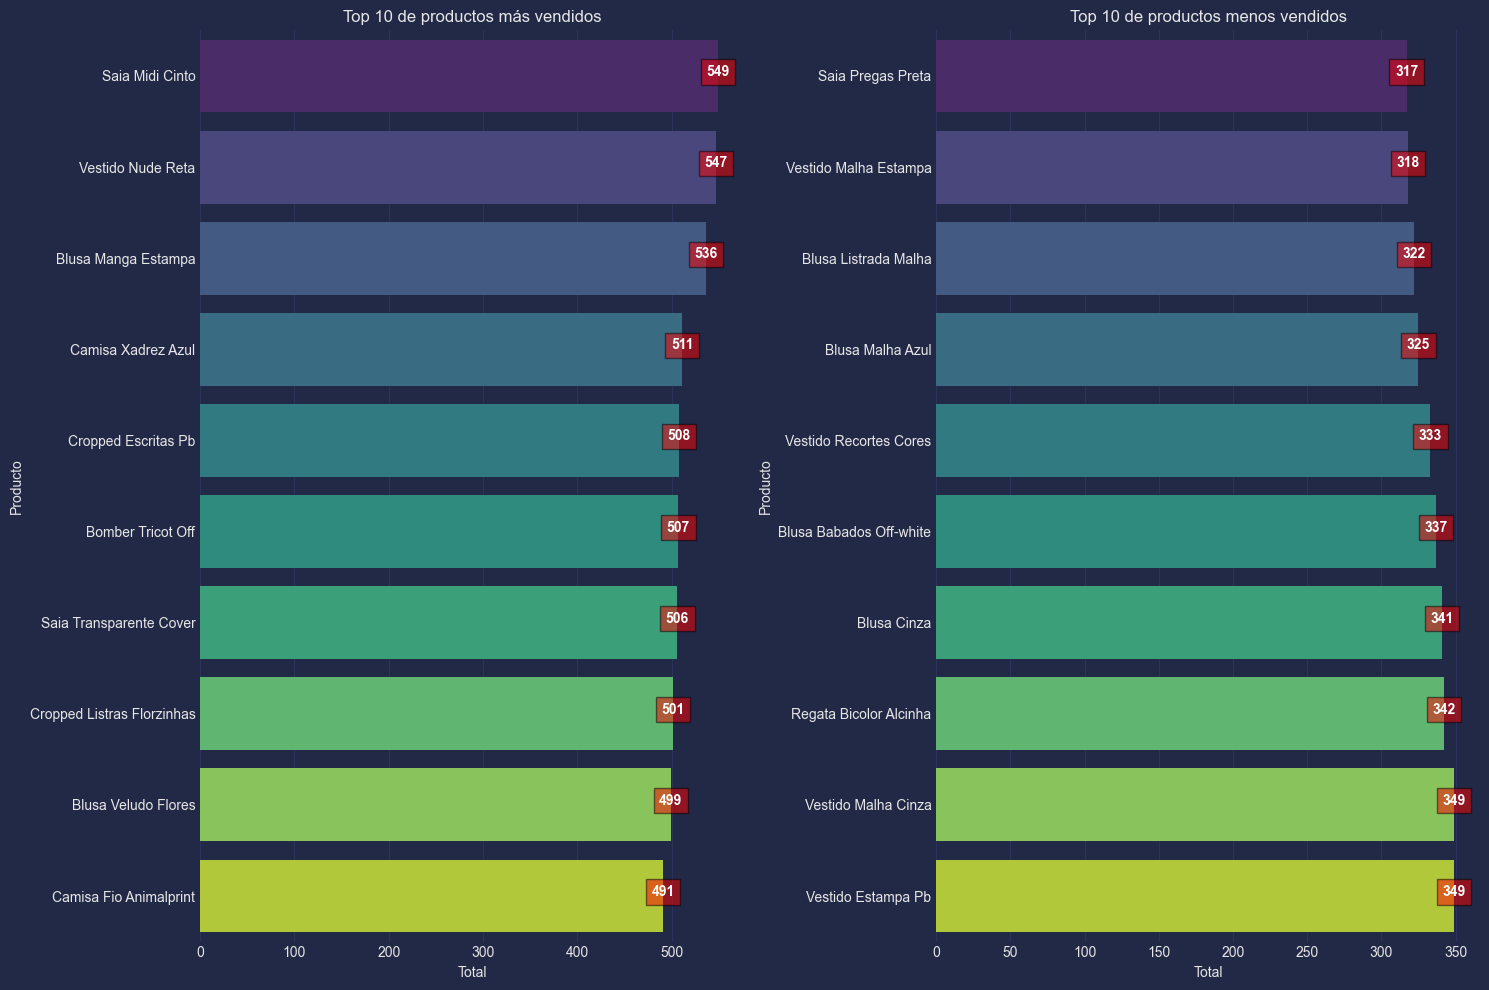

In [103]:
# Graficaremos el top 5 de productos más vendidos con seaborn
df = pd.DataFrame(respuesta, columns=['producto', 'total'])

# Ordenar el DataFrame de mayor a menor
df_top = df.sort_values('total', ascending=False).head(10)

# Ordenar el DataFrame de menor a mayor
df_bottom = df.sort_values('total', ascending=True).head(10)

# Crear una figura con dos subplots
fig, ax = plt.subplots(1, 2, figsize=(15, 10))

# Graficar los productos más vendidos
sns.barplot(x='total', y='producto', data=df_top, palette='viridis', hue='producto', ax=ax[0])
for i in range(df_top.shape[0]):
    ax[0].text(df_top.total.iloc[i], i, 
               round(df_top.total.iloc[i], 2), 
               horizontalalignment='center', 
               bbox=dict(facecolor='red', alpha=0.5),
               size='medium', 
               color='white', 
               weight='semibold')
ax[0].set_title('Top 10 de productos más vendidos')
ax[0].set_xlabel('Total')
ax[0].set_ylabel('Producto')

# Graficar los productos menos vendidos
sns.barplot(x='total', y='producto', data=df_bottom, palette='viridis', hue='producto', ax=ax[1])
for i in range(df_bottom.shape[0]):
    ax[1].text(df_bottom.total.iloc[i], i, 
               round(df_bottom.total.iloc[i], 2), 
               horizontalalignment='center', 
               bbox=dict(facecolor='red', alpha=0.5),
               size='medium', 
               color='white', 
               weight='semibold')
ax[1].set_title('Top 10 de productos menos vendidos')
ax[1].set_xlabel('Total')
ax[1].set_ylabel('Producto')

plt.tight_layout()
plt.show()

## **Pregunta 1.2: ¿Y Cual es el total de ganancias por cada producto?**

In [4]:
query = '''
SELECT p.producto, SUM(i.valor_total - i.costo_envio) AS ingresos_netos
FROM itens_pedidos i
JOIN productos p ON i.producto_id = p.producto_id
GROUP BY p.producto_id, p.producto
ORDER BY ingresos_netos DESC
'''
respuesta = consultar(query, engine)

2024-04-11 17:05:27,436 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-11 17:05:27,440 INFO sqlalchemy.engine.Engine 
SELECT p.producto, SUM(i.valor_total - i.costo_envio) AS ingresos_netos
FROM itens_pedidos i
JOIN productos p ON i.producto_id = p.producto_id
GROUP BY p.producto_id, p.producto
ORDER BY ingresos_netos DESC

2024-04-11 17:05:27,443 INFO sqlalchemy.engine.Engine [generated in 0.00256s] ()
2024-04-11 17:05:27,488 INFO sqlalchemy.engine.Engine ROLLBACK


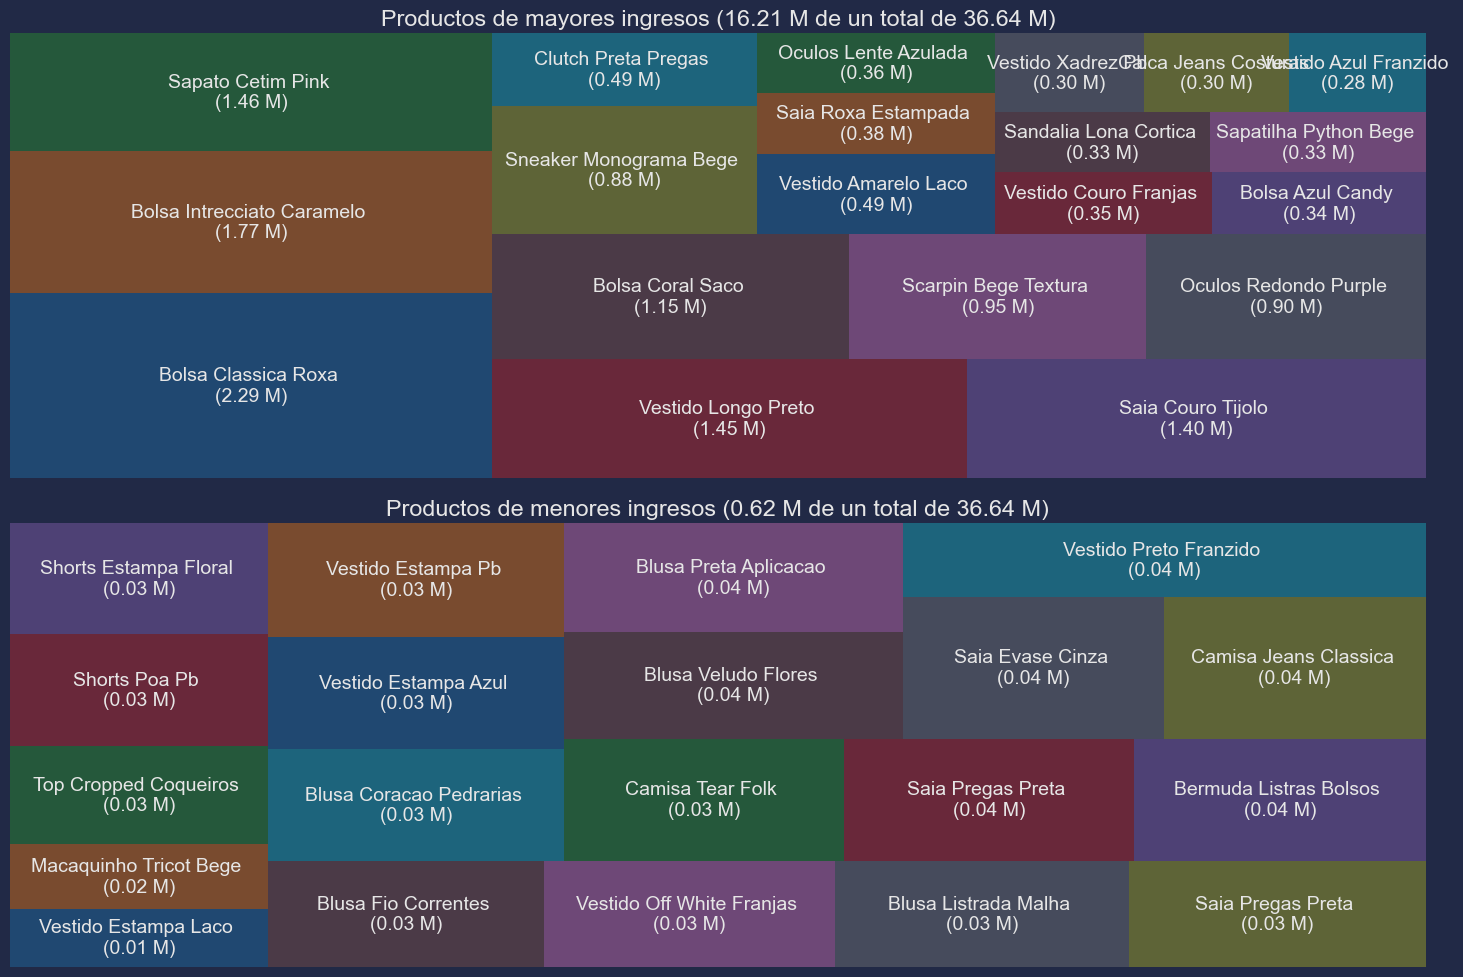

In [8]:
# Aumentar el tamaño de la fuente
plt.rcParams.update({'font.size': 14})

# Graficamos el treemap
df = pd.DataFrame(respuesta, columns=['producto', 'cantidad'])

# Ordenar el DataFrame de mayor a menor
df_top = df.sort_values('cantidad', ascending=False).head(20)

# Ordenar el DataFrame de menor a mayor
df_bottom = df.sort_values('cantidad', ascending=True).head(20)

# Crear una figura con dos subplots
fig, ax = plt.subplots(2, 1, figsize=(15, 10))

# Crear las etiquetas con el nombre del producto y la cantidad en millones
df_top['label'] = df_top.apply(lambda row: f"{row['producto']} \n({row['cantidad']/1e6:.2f} M)", axis=1)
df_bottom['label'] = df_bottom.apply(lambda row: f"{row['producto']} \n({row['cantidad']/1e6:.2f} M)", axis=1)

# Crear el treemap para los productos de mayores ingresos
ax[0].axis('off')
squarify.plot(sizes=df_top['cantidad'], label=df_top['label'], alpha=0.4, pad=False, color=plt.cm.tab10.colors, ax=ax[0])
ax[0].set_title(f'Productos de mayores ingresos ({df_top["cantidad"].sum()/1e6:.2f} M de un total de {df["cantidad"].sum()/1e6:.2f} M)')

# Crear el treemap para los productos de menores ingresos
ax[1].axis('off')
squarify.plot(sizes=df_bottom['cantidad'], label=df_bottom['label'], alpha=0.4, pad=False, color=plt.cm.tab10.colors, ax=ax[1])
ax[1].set_title(f'Productos de menores ingresos ({df_bottom["cantidad"].sum()/1e6:.2f} M de un total de {df["cantidad"].sum()/1e6:.2f} M)')

plt.tight_layout()
plt.show()

## **Pregunta 2: ¿Cual es la evolución histórica de las ingresos netos?**

In [39]:
# Cual es la evolucion histórica de los ingresos netos por dia (luego de costos de envio)
query = '''
SELECT fecha_compra, SUM(valor_total-costo_envio) AS ingresos_netos
FROM pedidos p
JOIN itens_pedidos i ON p.pedido_id = i.pedido_id
GROUP BY fecha_compra
'''
respuesta = consultar(query, engine)

2024-04-11 12:25:18,359 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-11 12:25:18,363 INFO sqlalchemy.engine.Engine 
SELECT fecha_compra, SUM(valor_total-costo_envio) AS ingresos_netos
FROM pedidos p
JOIN itens_pedidos i ON p.pedido_id = i.pedido_id
GROUP BY fecha_compra

2024-04-11 12:25:18,365 INFO sqlalchemy.engine.Engine [generated in 0.00243s] ()
2024-04-11 12:25:18,458 INFO sqlalchemy.engine.Engine ROLLBACK


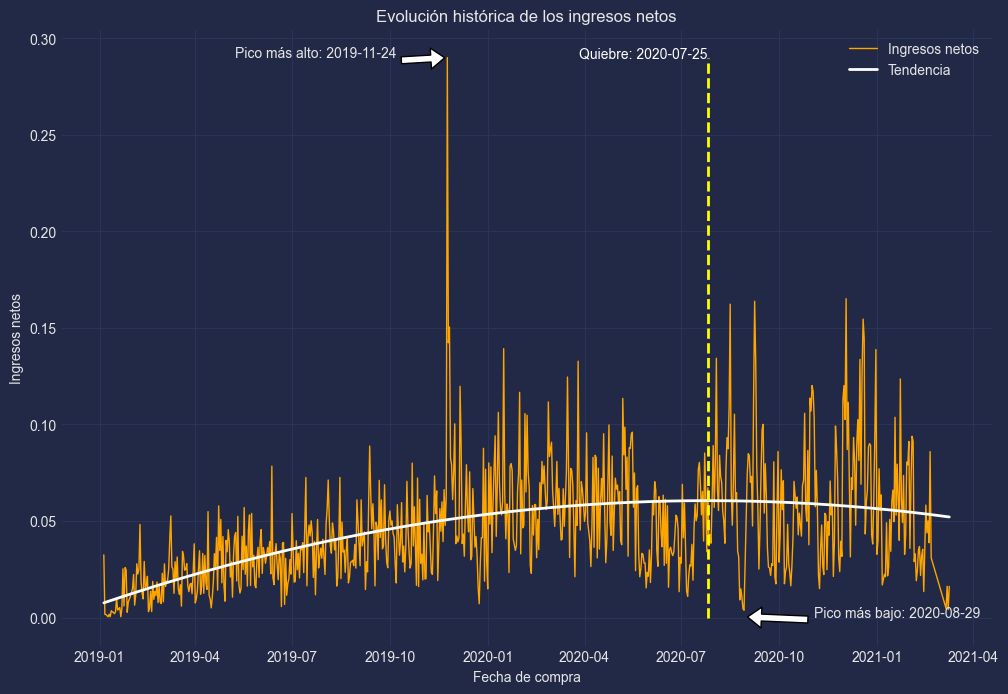

In [40]:
from scipy.optimize import minimize

# Graficaremos la evolución histórica de los ingresos netos
df = pd.DataFrame(respuesta, columns=['fecha_compra', 'ingresos_netos'])
df['ingresos_netos'] = df['ingresos_netos']/1000000
df['fecha_compra'] = pd.to_datetime(df['fecha_compra'])

# Ajustar una curva de tendencia
z = np.polyfit(df['fecha_compra'].astype('int64'), df['ingresos_netos'], 2)
p = np.poly1d(z)

# Calcular la derivada de la función polinómica
p_deriv = p.deriv()

# Función objetivo para la optimización (queremos encontrar donde la derivada es igual a cero)
objective = lambda x: np.abs(p_deriv(x))

# Valor inicial para la optimización (usamos el primer valor de la fecha)
x0 = df['fecha_compra'].astype('int64')[0]

# Encontrar el valor de 'x' que minimiza la función objetivo
result = minimize(objective, x0, method='Nelder-Mead')

# Convertir el resultado a una fecha
break_point = pd.to_datetime(result.x[0])

plt.figure(figsize=(12, 8))

# Dibujar los ingresos netos y la línea de tendencia
plt.plot(df['fecha_compra'], df['ingresos_netos'], color='orange', linewidth=1)
plt.plot(df['fecha_compra'], p(df['fecha_compra'].astype('int64')), color='white', linewidth=2)
plt.plot([break_point, break_point], [0, df['ingresos_netos'].max()], color='yellow', linestyle='--', linewidth=2)
plt.text(break_point, df['ingresos_netos'].max(), f'Quiebre: {break_point.date()}', color='white', ha='right')

# Encontrar la fecha del pico más alto
peak_date = df.loc[df['ingresos_netos'].idxmax(), 'fecha_compra']
# Agregar una anotación para la fecha del pico más alto
plt.annotate(f'Pico más alto: {peak_date.date()}', 
             xy=(peak_date, df['ingresos_netos'].max()), 
             xytext=(peak_date - pd.DateOffset(days=200), df['ingresos_netos'].max()), 
             arrowprops=dict(facecolor='white', shrink=0.05, headwidth=15, width=5, headlength=10, 
                             connectionstyle='arc3,rad=0')) # Hacer que la flecha sea horizontal

# Filtrar el DataFrame para incluir solo las fechas después del break_point
df_after_high_peak = df[df['fecha_compra'] > break_point]
# Encontrar la fecha del pico más bajo después del break_point
low_peak_date = df_after_high_peak.loc[df_after_high_peak['ingresos_netos'].idxmin(), 'fecha_compra']
# Agregar una anotación para la fecha del pico más bajo
plt.annotate(f'Pico más bajo: {low_peak_date.date()}', 
             xy=(low_peak_date, df['ingresos_netos'].min()), 
             xytext=(break_point + pd.DateOffset(days=100), df['ingresos_netos'].min()), 
             arrowprops=dict(facecolor='white', shrink=0.05, headwidth=15, width=5, headlength=10, 
                             connectionstyle='arc3,rad=0')) # Hacer que la flecha sea horizontal

plt.title('Evolución histórica de los ingresos netos')
plt.xlabel('Fecha de compra')
plt.ylabel('Ingresos netos')
plt.grid(True)
plt.legend(['Ingresos netos', 'Tendencia'])
plt.show()

## **Pregunta 3: ¿Cuáles son los ingresos netos por vendedor por año?**

In [126]:
# Cuales son los ingresos netos por vendedor (quiero el nombre del vendedor) por año
query = '''
SELECT strftime('%Y', fecha_compra) AS anio, v.nombre_vendedor AS vendedor, SUM(valor_total-costo_envio) AS ingresos_netos
FROM pedidos p
JOIN itens_pedidos i ON p.pedido_id = i.pedido_id
JOIN vendedores v ON p.vendedor_id = v.vendedor_id
GROUP BY anio, vendedor
'''
respuesta = consultar(query, engine)

2024-04-11 13:46:57,996 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-11 13:46:58,000 INFO sqlalchemy.engine.Engine 
SELECT strftime('%Y', fecha_compra) AS anio, v.nombre_vendedor AS vendedor, SUM(valor_total-costo_envio) AS ingresos_netos
FROM pedidos p
JOIN itens_pedidos i ON p.pedido_id = i.pedido_id
JOIN vendedores v ON p.vendedor_id = v.vendedor_id
GROUP BY anio, vendedor

2024-04-11 13:46:58,004 INFO sqlalchemy.engine.Engine [cached since 4690s ago] ()
2024-04-11 13:46:58,128 INFO sqlalchemy.engine.Engine ROLLBACK


<Figure size 1500x1000 with 0 Axes>

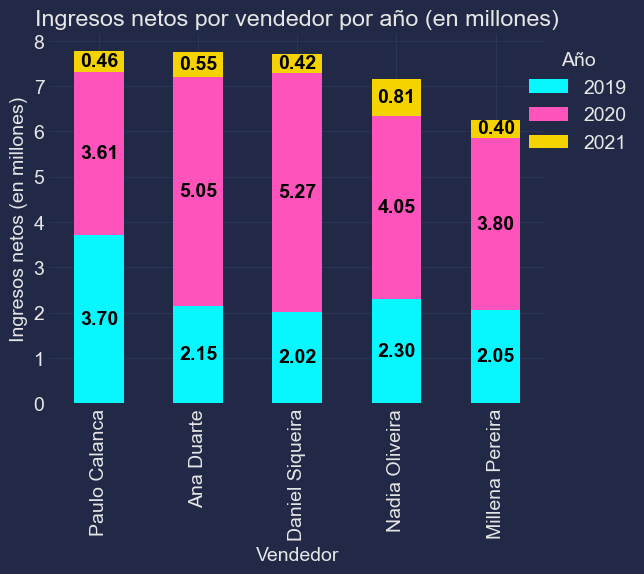

In [ ]:
# Graficaremos los ingresos netos por vendedor por año
df = pd.DataFrame(respuesta, columns=['anio', 'vendedor', 'ingresos_netos'])

# Excluir vendedor 'unknow'
df = df[df['vendedor'] != 'Unknown']

# Dividir los ingresos netos por un millón
df['ingresos_netos'] = df['ingresos_netos'] / 1e6

# Pivotear el DataFrame para que cada año sea una columna
df_pivot = df.pivot(index='vendedor', columns='anio', values='ingresos_netos').fillna(0)

# Ordenar el DataFrame pivotado de mayor a menor
df_pivot['total'] = df_pivot.sum(axis=1)
df_pivot = df_pivot.sort_values('total', ascending=False)
del df_pivot['total']

plt.figure(figsize=(15, 10))

# Crear un gráfico de barras apiladas
barplot = df_pivot.plot(kind='bar', stacked=True)

# Añadir los valores dentro de las barras
for rect in barplot.patches:
    height = rect.get_height()
    x = rect.get_x() + rect.get_width() / 2
    y = rect.get_y() + height / 2
    label = f'{height:.2f}'
    barplot.text(x, y, label, ha='center', va='center', color='black', weight='bold')

plt.title('Ingresos netos por vendedor por año (en millones)')
plt.ylabel('Ingresos netos (en millones)')
plt.xlabel('Vendedor')
plt.legend(loc='upper right', title='Año', bbox_to_anchor=(1.2, 1))
plt.show()

## **Pregunta 4: ¿Cuáles son las ciudades que proporcionan mayores ingresos netos?**

In [43]:
# Cuales son los ingresos netos por estado (luego de costos de envio)
query = '''
SELECT ciudad, SUM(valor_total-costo_envio) AS ingresos_netos
FROM pedidos p
JOIN itens_pedidos i ON p.pedido_id = i.pedido_id
GROUP BY ciudad
'''
respuesta = consultar(query, engine)

2024-04-11 12:35:19,153 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2024-04-11 12:35:19,158 INFO sqlalchemy.engine.Engine 
SELECT ciudad, SUM(valor_total-costo_envio) AS ingresos_netos
FROM pedidos p
JOIN itens_pedidos i ON p.pedido_id = i.pedido_id
GROUP BY ciudad

2024-04-11 12:35:19,160 INFO sqlalchemy.engine.Engine [generated in 0.00250s] ()
2024-04-11 12:35:19,238 INFO sqlalchemy.engine.Engine ROLLBACK


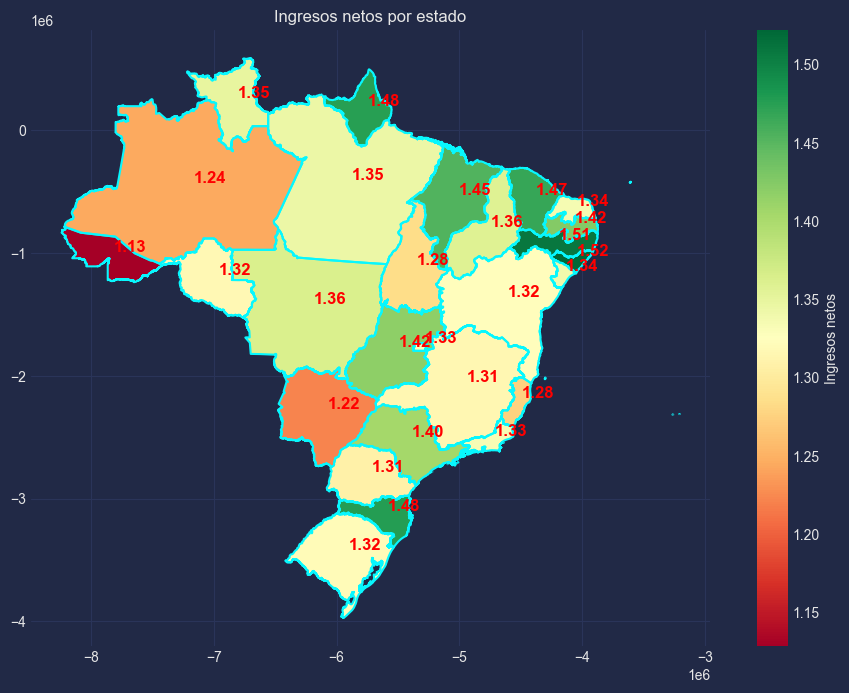

In [54]:
# Realizamos el grafico en geobr
df = pd.DataFrame(respuesta, columns=['ciudad', 'ingresos_netos'])
df['ingresos_netos'] = df['ingresos_netos']/1000000
gdf = geobr.read_state()
gdf = gdf.merge(df, left_on='abbrev_state', right_on='ciudad')

# Proyectar a un CRS proyectado
gdf = gdf.to_crs('EPSG:3395')

fig, ax = plt.subplots(1, 1, figsize=(12, 8))
gdf.boundary.plot(ax=ax)

# Cambiar el mapa de colores a 'semaforo'
gdf.plot(column='ingresos_netos', ax=ax, legend=True, cmap='RdYlGn', legend_kwds={'label': "Ingresos netos"})

# Mostrar los valores de ventas para cada estado
for x, y, label in zip(gdf.geometry.centroid.x, gdf.geometry.centroid.y, gdf['ingresos_netos']):
    ax.annotate(f'{label:.2f}', xy=(x, y), xytext=(3,3), textcoords="offset points", color='red', fontsize=12, weight='bold')

plt.title('Ingresos netos por estado')
plt.show()